In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score
import model
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, SGDClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

def impute(df, label_column='GROUP'):
    imputed_dfs = []
    for group_value in df[label_column].unique().tolist():
        # Extract the non-numeric column and the numeric columns
        non_numeric_column = df[df[label_column] == group_value].iloc[:, :2].reset_index(drop=True)
        numeric_data = df[df[label_column] == group_value].iloc[:, 2:].reset_index(drop=True)

        # Initialize the KNNImputer
        knn_imputer = KNNImputer(n_neighbors=5)

        # Impute the missing values in the numeric data
        imputed_numeric_data = knn_imputer.fit_transform(numeric_data)

        # Create a new DataFrame with the imputed values
        imputed_data_frame = pd.DataFrame(imputed_numeric_data, columns=numeric_data.columns)

        imputed_data_frame = pd.concat([non_numeric_column, imputed_data_frame], axis=1)
        imputed_dfs.append(imputed_data_frame)

    return pd.concat(imputed_dfs).reset_index(drop=True)

df_Turkish_meta = pd.read_csv('../src/Turkish meta.txt', sep='\t')
df_Turkish_data = pd.read_csv('../src/Turkish data.txt', sep='\t')
df_Swedish_meta = pd.read_csv('../src/Swedish meta.txt', sep='\t')
df_Swedish_data = pd.read_csv('../src/Swedish data.txt', sep='\t')

df_Turkish = df_Turkish_meta.merge(df_Turkish_data, on='DAid')
df_Swedish = df_Swedish_meta.merge(df_Swedish_data, on='DAid')

df_combined = pd.concat([df_Turkish, df_Swedish], axis=0).reset_index(drop=True)

df_combined_imputed = impute(df_combined)

Disease_list = ['LIVD-Chronic Liver Disease (CLD)', 'LIVD-ARLD', 
                'LIVD-Hepatocellular Carcinoma (HCC)', 'LIVD-VIRAL', 'LIVD-MASLD', 
                'PANC-pancreas cancer', 'PSYC-bipolar', 'PSYC-schizophrenia', 'THEL- ', 'COLC- ', 
                'AML', 'BRC', 'CLL', 'CVX', 'ENDC', 'GLIOM', 'LUNGC', 'LYMPH', 'MENI', 'MYEL', 'OVC', 'PIT-NET', 
                'PRC', 'SI-NET']

disease_mapping = {disease: i for i, disease in enumerate(Disease_list)}

df_train_test_cohort = df_combined_imputed[df_combined_imputed['GROUP'].isin(Disease_list)].reset_index(drop=True)


x, y = df_train_test_cohort.iloc[:,2:].values, np.array([disease_mapping[disease] for disease in df_train_test_cohort['GROUP'].tolist()], dtype=int)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3, stratify=y)

In [8]:
disease_mapping

{'LIVD-Chronic Liver Disease (CLD)': 0,
 'LIVD-ARLD': 1,
 'LIVD-Hepatocellular Carcinoma (HCC)': 2,
 'LIVD-VIRAL': 3,
 'LIVD-MASLD': 4,
 'PANC-pancreas cancer': 5,
 'PSYC-bipolar': 6,
 'PSYC-schizophrenia': 7,
 'THEL- ': 8,
 'COLC- ': 9,
 'AML': 10,
 'BRC': 11,
 'CLL': 12,
 'CVX': 13,
 'ENDC': 14,
 'GLIOM': 15,
 'LUNGC': 16,
 'LYMPH': 17,
 'MENI': 18,
 'MYEL': 19,
 'OVC': 20,
 'PIT-NET': 21,
 'PRC': 22,
 'SI-NET': 23}

In [2]:
# Define the IDs for each category group
blood_id = [8, 10, 12, 17, 19]
liver_id = [0, 1, 2, 3, 4]
psych_id = [6, 7]
cancer_id = [5, 9, 11, 13, 14, 15, 16, 18, 20, 21, 22, 23]

first_layer_borderline = (True, 6, 8)
blood_borderline = (True, 4, 13)
liver_borderline = (True, 9, 7)
psych_borderline = (True, 4, 3)
cancer_borderline = (True, 1, 10)

# Initialize the classifiers
multi_classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', Perceptron(penalty='l1', alpha=1e-7, random_state=3, n_jobs=-1)),
])

blood_classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', ExtraTreesClassifier(random_state=3, n_jobs=-1)),
])

liver_classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RidgeClassifier(alpha=0.1, random_state=3, solver='svd')),
])

psych_classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SGDClassifier(random_state=3, n_jobs=-1)),
])

cancer_classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty='l2', C=0.01, solver='liblinear', random_state=3, n_jobs=-1)),
])

# Create an instance of the hierarchical classifier
hierarchical_classifier = model.HierarchicalClassifier(
    multi_classifier,
    blood_classifier,
    liver_classifier,
    psych_classifier,
    cancer_classifier,
    blood_id,
    liver_id,
    psych_id,
    cancer_id,
    first_layer_borderline, blood_borderline, liver_borderline, psych_borderline, cancer_borderline, random_state=3
)

hierarchical_classifier.fit(x_train, y_train)

In [3]:
y_pred = hierarchical_classifier.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.8188976377952756
F1: 0.814337789966257


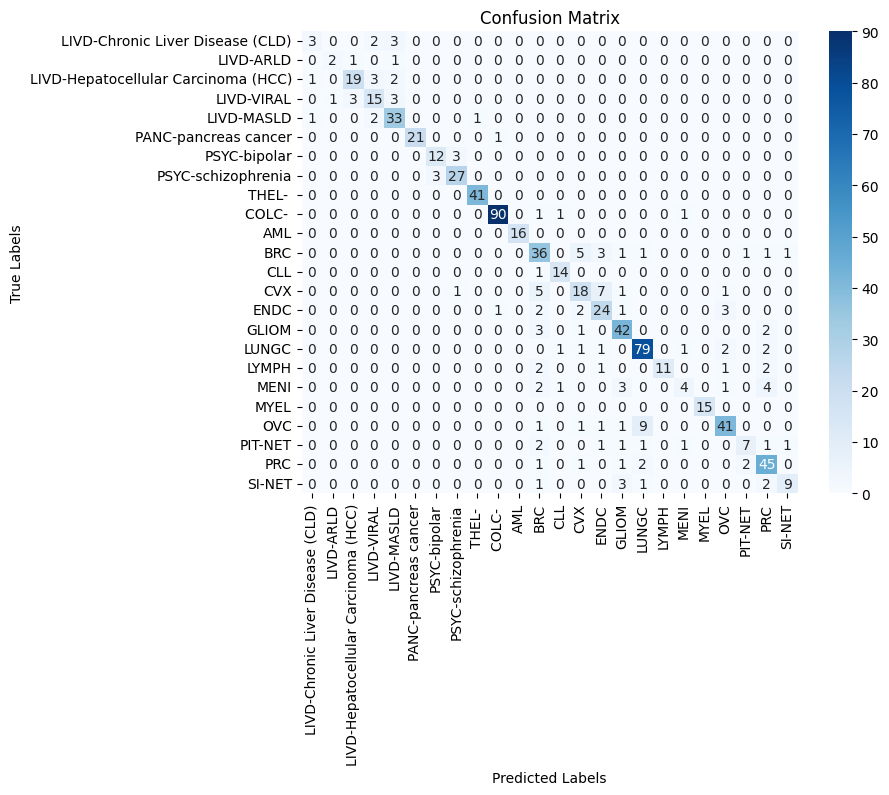

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=list(disease_mapping.keys()), yticklabels=list(disease_mapping.keys()), cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [5]:
# the baseline algorithm

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=3, n_jobs=-1)),
])

# param_grid = {
#     'clf__C': [0.01, 0.1, 1],                  
#     'clf__solver': ['liblinear', 'lbfgs'],   
# }

param_grid = {
    'clf__penalty': ['l1', 'l2', None],
    'clf__C': [0.001, 0.005, 0.01],
    'clf__solver': ['lbfgs', 'liblinear']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5).fit(x_train, y_train)

print("Accuracy:", accuracy_score(y_test, grid_search.predict(x_test)))
print("F1:", f1_score(y_test, grid_search.predict(x_test), average='weighted'))

Accuracy: 0.7992125984251969
F1: 0.781640593249087


In [6]:
print("Extra gain in Accuracy: ", accuracy_score(y_test, y_pred)-accuracy_score(y_test, grid_search.predict(x_test)))
print("Extra gain in weighted F1: ", f1_score(y_test, y_pred, average='weighted')-f1_score(y_test, grid_search.predict(x_test), average='weighted'))
print("Extra gain in macro F1: ", f1_score(y_test, y_pred, average='macro')-f1_score(y_test, grid_search.predict(x_test), average='macro'))

Extra gain in Accuracy:  0.019685039370078705
Extra gain in weighted F1:  0.032697196717170085
Extra gain in macro F1:  0.06281566771313118


In [7]:
import pickle

with open('hierarchical_classifier.pkl', 'wb') as f:
    pickle.dump(hierarchical_classifier, f)